# Experiments (15-Minute Interval)

This notebook completes **EDA, feature testing, hyperparameter tuning, validation plots, backtesting, and final model design selection** for the XGBoost trading strategy using **15-minute bar data**.

All graphs and artifacts are saved into the `reports/` folder.

## 1) Setup and Imports

In [13]:
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

warnings.filterwarnings('ignore')

# Import project modules
from src.data_fetcher import DataFetcher
from src.feature_engineering import FeatureEngineer
from src.config import (
    STOCK_SYMBOL, XGB_PARAMS, TEST_SIZE, RANDOM_STATE,
    DATA_INTERVAL, DATA_DAYS,
    TARGET_ACCURACY, TARGET_SHARPE, TARGET_MAX_DRAWDOWN,
    STOP_LOSS_PCT, TAKE_PROFIT_PCT,
)

# Create reports directory
REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f'Setup complete. Interval: {DATA_INTERVAL} | Reports -> {REPORTS_DIR.resolve()}')
print(f'Targets: Accuracy ≥ {TARGET_ACCURACY:.0%} | Sharpe ≥ {TARGET_SHARPE} | Max DD ≤ {TARGET_MAX_DRAWDOWN:.0%}')

Setup complete. Interval: 15m | Reports -> C:\Users\jieha\fyp2\reports
Targets: Accuracy ≥ 55% | Sharpe ≥ 0.5 | Max DD ≤ 10%


## 2) Load and Prepare Data

Fetch **15-minute interval** historical data via `DataFetcher` (Yahoo Finance) and engineer all technical indicators with `FeatureEngineer`.

In [14]:
# Try loading from local CSV first; fall back to live download
csv_path = f'data/{STOCK_SYMBOL}_{DATA_INTERVAL}.csv'

if os.path.exists(csv_path):
    df_raw = pd.read_csv(csv_path, index_col='date', parse_dates=True)
    print(f'Loaded local CSV: {csv_path}')
else:
    print(f'Local CSV not found - downloading {STOCK_SYMBOL} {DATA_INTERVAL} from Yahoo Finance...')
    fetcher = DataFetcher(symbol=STOCK_SYMBOL, interval=DATA_INTERVAL)
    df_raw = fetcher.get_historical_data(days=DATA_DAYS)

# Engineer features (fixed set — no feature selection needed)
engineer = FeatureEngineer()
df = engineer.create_features(df_raw)

# Prepare X, y with the fixed feature column list
X_all, y_all, FEATURE_COLUMNS = engineer.prepare_training_data(df)

print(f'Interval: {DATA_INTERVAL}')
print(f'Rows (after dropna): {len(X_all)}')
print(f'Feature columns ({len(FEATURE_COLUMNS)}): {FEATURE_COLUMNS}')
print(f'Date range: {X_all.index.min()} to {X_all.index.max()}')

df.head()

Loaded local CSV: data/AAPL_15m.csv
Interval: 15m
Rows (after dropna): 976
Feature columns (8): ['Return', 'EMA_10', 'EMA_20', 'RSI_14', 'MACD_Hist', 'Volatility_14', 'Return_Lag_1', 'Return_Lag_3']
Date range: 2025-12-29 18:00:00+00:00 to 2026-02-25 18:00:00+00:00


,open,high,low,close,volume,Return,EMA_10,EMA_20,RSI_14,MACD_Hist,Volatility_14,Return_Lag_1,Return_Lag_3,Target
date,,,,,,,,,,,,,,
2025-12-29 14:30:00+00:00,272.690002,274.359985,272.390015,273.665009,1826316,NaN,273.665009,273.665009,NaN,0.000000,NaN,NaN,NaN,1
2025-12-29 14:45:00+00:00,273.690002,274.070007,273.489990,273.859985,567304,0.000712,273.772246,273.767371,NaN,0.001944,NaN,NaN,NaN,0
2025-12-29 15:00:00+00:00,273.869995,273.989014,272.920013,273.109985,649918,-0.002739,273.506021,273.525983,NaN,-0.011870,NaN,0.000712,NaN,1
2025-12-29 15:15:00+00:00,273.119995,274.019897,273.111511,273.954315,661533,0.003092,273.653714,273.649636,NaN,0.005961,NaN,-0.002739,NaN,0
2025-12-29 15:30:00+00:00,273.950012,274.029999,273.739990,273.760010,467778,-0.000709,273.684229,273.676334,NaN,0.006681,NaN,0.003092,0.000712,0


## 3) Exploratory Data Analysis (EDA)

Overview of price action, return distribution, target class balance, and feature correlations.

        count          mean           std            min            25%  \
close   989.0  2.637921e+02  8.653003e+00     244.490005     257.720001   
Return  989.0  8.125451e-06  3.544188e-03      -0.017953      -0.001296   
volume  989.0  1.226918e+06  1.677009e+06  115253.000000  508616.000000   
Target  989.0  4.641052e-01  4.989622e-01       0.000000       0.000000   

                  50%           75%           max  
close      262.359985  2.724900e+02  2.805250e+02  
Return      -0.000124  1.080622e-03  4.785814e-02  
volume  726462.000000  1.133389e+06  1.539122e+07  
Target       0.000000  1.000000e+00  1.000000e+00  


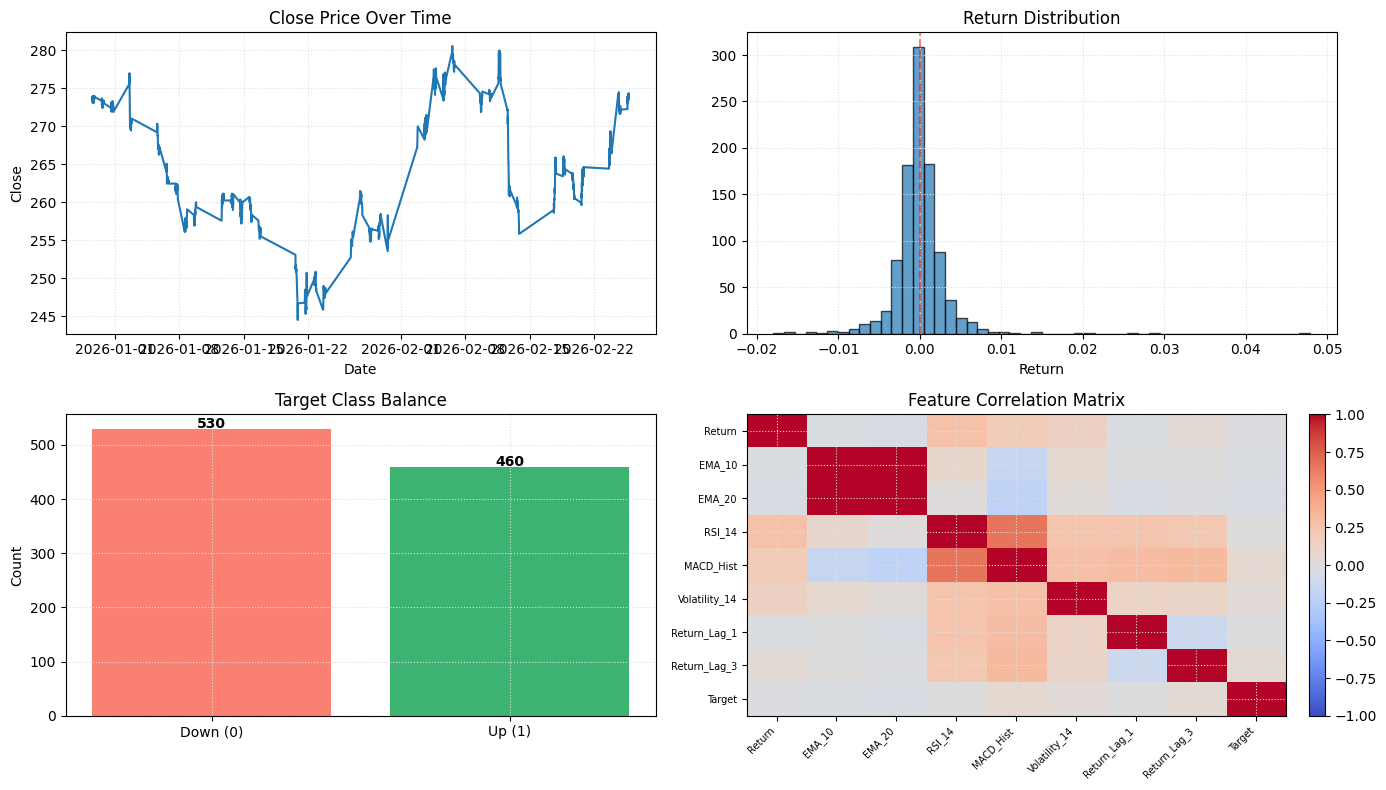

Saved: reports/eda_summary.png


In [15]:
eda_cols = ['close', 'Return', 'volume', 'Target']
print(df.dropna(subset=eda_cols)[eda_cols].describe().T)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# (0,0) Close price over time
axes[0, 0].plot(df.index, df['close'])
axes[0, 0].set_title('Close Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close')

# (0,1) Return distribution
axes[0, 1].hist(df['Return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Return Distribution')
axes[0, 1].set_xlabel('Return')
axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.5)

# (1,0) Target class balance (binary: 0 = Down, 1 = Up)
class_counts = df['Target'].value_counts().sort_index().reindex([0, 1], fill_value=0)
axes[1, 0].bar(['Down (0)', 'Up (1)'], class_counts.values, color=['salmon', 'mediumseagreen'])
axes[1, 0].set_title('Target Class Balance')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    axes[1, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# (1,1) Feature correlation matrix
corr = df[FEATURE_COLUMNS + ['Target']].dropna().corr()
im = axes[1, 1].imshow(corr.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 1].set_title('Feature Correlation Matrix')
axes[1, 1].set_xticks(range(len(corr.columns)))
axes[1, 1].set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=7)
axes[1, 1].set_yticks(range(len(corr.columns)))
axes[1, 1].set_yticklabels(corr.columns, fontsize=7)
fig.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'eda_summary.png', dpi=150)
plt.show()
print('Saved: reports/eda_summary.png')

## 4) Train / Test Split

Use a chronological 80/20 split (no shuffling) to respect time-series ordering.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=False,            # preserve chronological order
)

# Keep a copy of the full test DataFrame for backtesting later
# Use the same rows as X_all (i.e. rows where features + Target are not NaN)
df_clean = df.loc[X_all.index]
split_idx = len(X_train)
test_df = df_clean.iloc[split_idx:]

print(f'Train size: {len(X_train)}')
print(f'Test size:  {len(X_test)}')
print(f'Train period: {X_train.index.min().date()} → {X_train.index.max().date()}')
print(f'Test  period: {X_test.index.min().date()} → {X_test.index.max().date()}')

Train size: 780
Test size:  196
Train period: 2025-12-29 → 2026-02-13
Test  period: 2026-02-13 → 2026-02-25


## 5) Baseline Model and Feature Importance

Baseline accuracy: 0.4847  (target ≥ 0.55)


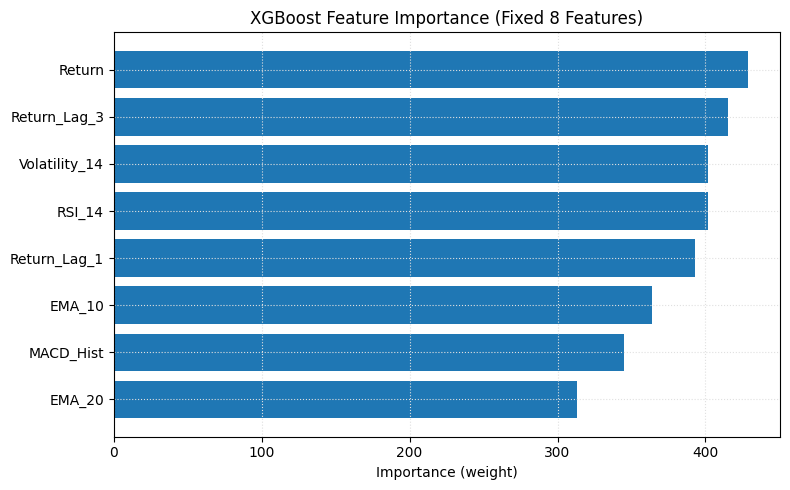

Saved: reports/feature_importance.png


,Feature,Importance
0,Return,429.0
1,Return_Lag_3,415.0
2,Volatility_14,402.0
3,RSI_14,402.0
4,Return_Lag_1,393.0
5,EMA_10,364.0
6,MACD_Hist,345.0
7,EMA_20,313.0


In [17]:
# Train baseline model with default XGB_PARAMS on the fixed feature set
baseline_model = xgb.XGBClassifier(**XGB_PARAMS)
baseline_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

baseline_preds = baseline_model.predict(X_test)
baseline_test_acc = accuracy_score(y_test, baseline_preds)
print(f'Baseline accuracy: {baseline_test_acc:.4f}  (target ≥ {TARGET_ACCURACY})')

# Feature importance (all 8 fixed features)
importance = baseline_model.get_booster().get_score(importance_type='weight')
importance_df = (
    pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance (Fixed 8 Features)')
plt.xlabel('Importance (weight)')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'feature_importance.png', dpi=150)
plt.show()
print('Saved: reports/feature_importance.png')

importance_df

## 6) Feature Set Verification

The feature set is **fixed** — no ablation or feature selection is performed. All 8 features are always used.

In [18]:
# Fixed feature set — no ablation needed
selected_features = FEATURE_COLUMNS
print(f'Fixed feature set ({len(selected_features)} features):')
for i, feat in enumerate(selected_features, 1):
    print(f'  {i}. {feat}')

# Quick sanity check: all features present in data
assert all(f in X_train.columns for f in selected_features), 'Missing features!'
print('\nAll features present in training data ✓')

Fixed feature set (8 features):
  1. Return
  2. EMA_10
  3. EMA_20
  4. RSI_14
  5. MACD_Hist
  6. Volatility_14
  7. Return_Lag_1
  8. Return_Lag_3

All features present in training data ✓


## 7) Hyperparameter Tuning (Time-Series CV)

Run a grid search with `TimeSeriesSplit` on the **fixed 8-feature set**.

In [19]:
print(f'Tuning on fixed feature set: {selected_features}')

# Grid search targeting Accuracy ≥ 55 %
base_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
)

param_grid = {
    'n_estimators':     [200, 300, 400],
    'max_depth':        [3, 4, 5],
    'learning_rate':    [0.01, 0.03, 0.05],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha':        [0, 0.1],
    'reg_lambda':       [1.0, 2.0],
}

tscv = TimeSeriesSplit(n_splits=4)
search = GridSearchCV(
    estimator=base_estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1,
    verbose=0,
)

search.fit(X_train[selected_features], y_train)

best_model  = search.best_estimator_
best_cv_score = search.best_score_
best_params = search.best_params_

print(f'Best CV accuracy: {best_cv_score:.4f}  (target ≥ {TARGET_ACCURACY})')
print(f'Best params: {best_params}')

# Compare baseline vs tuned
tuned_preds = best_model.predict(X_test[selected_features])
tuned_test_acc = accuracy_score(y_test, tuned_preds)

comparison_df = pd.DataFrame([
    {'model': 'baseline',  'test_accuracy': baseline_test_acc},
    {'model': 'tuned',     'test_accuracy': tuned_test_acc},
]).sort_values('test_accuracy', ascending=False)

comparison_df

Tuning on fixed feature set: ['Return', 'EMA_10', 'EMA_20', 'RSI_14', 'MACD_Hist', 'Volatility_14', 'Return_Lag_1', 'Return_Lag_3']
Best CV accuracy: 0.5272  (target ≥ 0.55)
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 1.0}


,model,test_accuracy
1,tuned,0.535714
0,baseline,0.484694


## 8) Validation Plots and Diagnostics

              precision    recall  f1-score   support

        Down     0.5500    0.8224    0.6592       107
          Up     0.4722    0.1910    0.2720        89

    accuracy                         0.5357       196
   macro avg     0.5111    0.5067    0.4656       196
weighted avg     0.5147    0.5357    0.4834       196



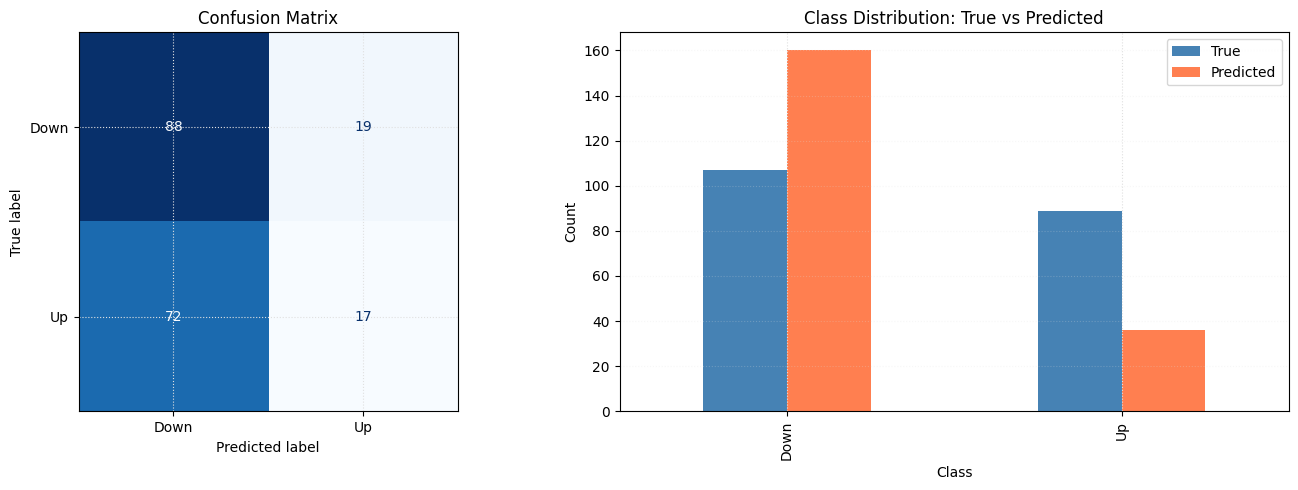

Saved: reports/validation_plots.png


In [20]:
preds = best_model.predict(X_test[selected_features])
proba = best_model.predict_proba(X_test[selected_features])

action_labels = ['Down', 'Up']
label_ids = [0, 1]

print(classification_report(y_test, preds, labels=label_ids, target_names=action_labels, digits=4))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, preds,
    labels=label_ids,
    display_labels=action_labels,
    ax=axes[0],
    colorbar=False,
    cmap='Blues',
)
axes[0].set_title('Confusion Matrix')

# Class distribution comparison
class_compare = pd.DataFrame({
    'True': y_test.value_counts().sort_index(),
    'Predicted': pd.Series(preds, index=y_test.index).value_counts().sort_index(),
}).reindex(label_ids).fillna(0)
class_compare.index = action_labels
class_compare.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Class Distribution: True vs Predicted')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.25)
axes[1].legend()

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'validation_plots.png', dpi=150)
plt.show()
print('Saved: reports/validation_plots.png')

## 9) Backtest Using Final Model

Simple long-only backtest on **15-minute bars**: Buy when the model predicts **Up (1)**, sell / stay in cash when it predicts **Down (0)**.

Stop-loss (20 %) and take-profit (20 %) are based on the **individual order value**, not the total portfolio.

Features:          ['Return', 'EMA_10', 'EMA_20', 'RSI_14', 'MACD_Hist', 'Volatility_14', 'Return_Lag_1', 'Return_Lag_3']
Interval:          15m
Stop-loss:         20.0% (per order)  |  Take-profit: 20.0% (per order)
Initial capital:   $100,000.00
Final capital:     $99,997.20
Cumulative return: -0.00%

  Accuracy:    0.5357   ✗ target ≥ 0.55
  Sharpe:      -9.357    ✗ target ≥ 0.5
  Max DD:      -0.00%   ✓ target ≤ 10%
  Win rate:    50.00%
  Trades:      15  (buys: 9, sells: 6)

Sample buy trades (confidence → shares):
                     date  confidence  investment  shares      price
2026-02-17 14:30:00+00:00    0.566594  266.377167       1 258.959991
2026-02-17 15:45:00+00:00    0.601834  407.337402       1 259.148102
2026-02-17 19:00:00+00:00    0.574070  296.279388       1 265.640015
2026-02-20 16:15:00+00:00    0.561343  245.371536       0 261.429993
2026-02-23 16:00:00+00:00    0.559791  239.164780       0 264.850006
2026-02-24 14:30:00+00:00    0.593403  373.613556       1 2

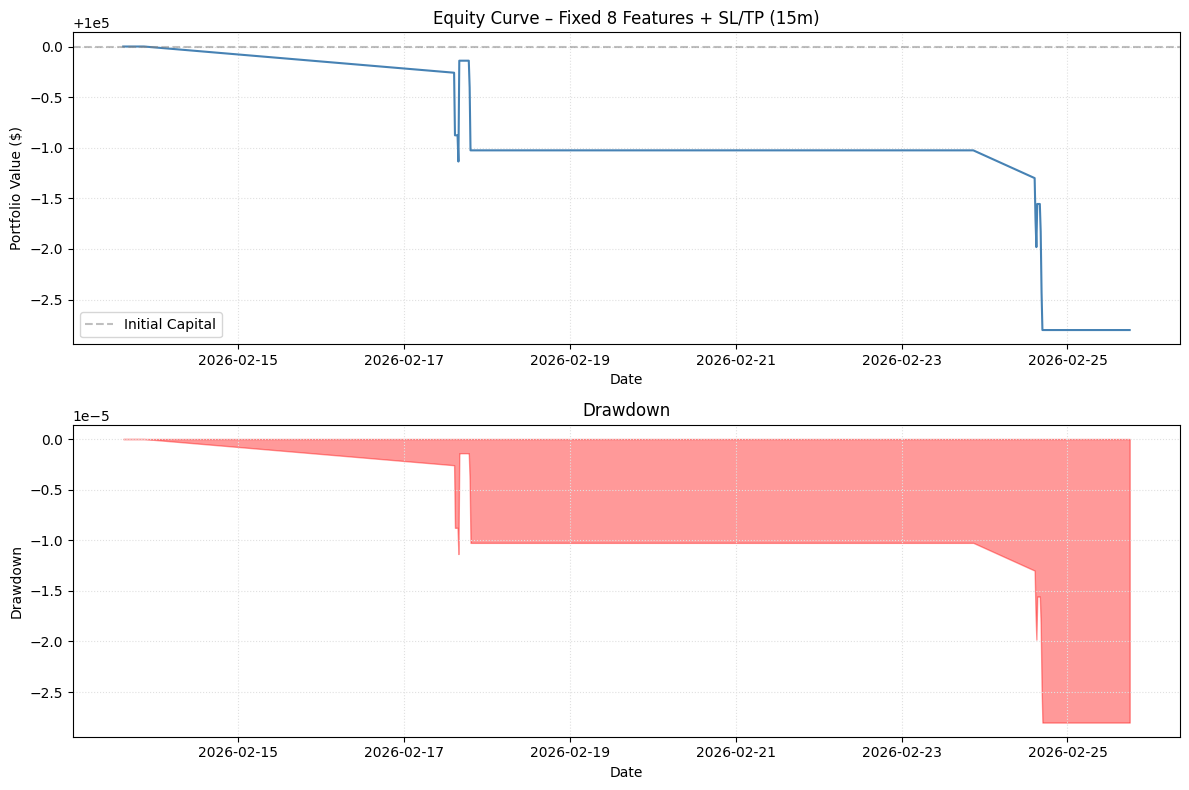

Saved: reports/equity_drawdown.png


In [21]:
# ---------- Confidence-based backtest engine with SL / TP ----------
CONFIDENCE_THRESHOLD = 0.55           # only trade on high-confidence signals
STOP_LOSS   = STOP_LOSS_PCT          # from config (default 20 %)
TAKE_PROFIT = TAKE_PROFIT_PCT        # from config (default 20 %)

def simple_backtest(test_df, predictions, probabilities, initial_capital=100_000,
                    transaction_cost=0.001, min_investment=200, max_investment=2000,
                    stop_loss=STOP_LOSS, take_profit=TAKE_PROFIT):
    """
    Long-only backtest on 15m bars with:
      • Confidence-based position sizing
      • Per-order stop-loss (20 %) & take-profit (20 %)
        — SL/TP are based on the individual order value, NOT the total portfolio
    Targets: Sharpe ≥ 0.5, Max Drawdown ≤ 10 %
    """
    capital = initial_capital
    shares = 0
    entry_price = 0.0
    portfolio_values = []
    trade_log = []

    for i, (date, row) in enumerate(test_df.iterrows()):
        price = row['close']
        pred = predictions[i]
        prob_up = probabilities[i, 1]

        # ── Check stop-loss / take-profit while holding ──────────
        #    pnl_pct is relative to the ORDER entry price, not total portfolio
        if shares > 0:
            pnl_pct = (price - entry_price) / entry_price
            if pnl_pct <= -stop_loss:
                revenue = shares * price * (1 - transaction_cost)
                capital += revenue
                trade_log.append({
                    'date': date, 'action': 'SELL (SL)', 'price': price,
                    'shares': shares, 'capital': capital,
                    'confidence': prob_up, 'investment': 0,
                })
                shares = 0
                entry_price = 0.0
            elif pnl_pct >= take_profit:
                revenue = shares * price * (1 - transaction_cost)
                capital += revenue
                trade_log.append({
                    'date': date, 'action': 'SELL (TP)', 'price': price,
                    'shares': shares, 'capital': capital,
                    'confidence': prob_up, 'investment': 0,
                })
                shares = 0
                entry_price = 0.0

        # ── Buy signal — high confidence only ────────────────────
        if pred == 1 and shares == 0 and prob_up >= CONFIDENCE_THRESHOLD:
            scale = (prob_up - CONFIDENCE_THRESHOLD) / (1.0 - CONFIDENCE_THRESHOLD)
            scale = max(0.0, min(1.0, scale))
            investment = min_investment + scale * (max_investment - min_investment)
            investment = min(investment, capital)
            shares = int(investment / (price * (1 + transaction_cost)))
            cost = shares * price * (1 + transaction_cost)
            capital -= cost
            entry_price = price
            trade_log.append({
                'date': date, 'action': 'BUY', 'price': price,
                'shares': shares, 'capital': capital,
                'confidence': prob_up, 'investment': investment,
            })

        # ── Sell signal (model says down) ────────────────────────
        elif pred == 0 and shares > 0:
            revenue = shares * price * (1 - transaction_cost)
            capital += revenue
            trade_log.append({
                'date': date, 'action': 'SELL', 'price': price,
                'shares': shares, 'capital': capital,
                'confidence': prob_up, 'investment': 0,
            })
            shares = 0
            entry_price = 0.0

        portfolio_value = capital + shares * price
        portfolio_values.append({'date': date, 'PortfolioValue': portfolio_value,
                                 'Capital': capital, 'Shares': shares})

    results = pd.DataFrame(portfolio_values).set_index('date')
    trade_log_df = pd.DataFrame(trade_log)
    return results, trade_log_df


# ---------- Performance metrics ----------
BARS_PER_YEAR = 26 * 252

def calc_sharpe(returns, periods=BARS_PER_YEAR):
    if returns.std() == 0:
        return 0
    return np.sqrt(periods) * returns.mean() / returns.std()


def calc_max_drawdown(portfolio_values):
    cum_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cum_max) / cum_max
    return drawdown.min()


# ---------- Run backtest on fixed features ----------
final_predictions = best_model.predict(X_test[selected_features])
final_probabilities = best_model.predict_proba(X_test[selected_features])
initial_capital = 100_000

results, trade_log = simple_backtest(
    test_df, final_predictions, final_probabilities,
    initial_capital=initial_capital,
    min_investment=200, max_investment=2000,
    stop_loss=STOP_LOSS, take_profit=TAKE_PROFIT,
)

bar_returns = results['PortfolioValue'].pct_change().dropna()
final_capital  = results['PortfolioValue'].iloc[-1]
cum_return     = (final_capital - initial_capital) / initial_capital
sharpe         = calc_sharpe(bar_returns)
max_dd         = calc_max_drawdown(results['PortfolioValue'])
num_trades     = len(trade_log)
num_buys       = (trade_log['action'] == 'BUY').sum() if len(trade_log) else 0
num_sells      = trade_log['action'].str.startswith('SELL').sum() if len(trade_log) else 0
win_rate       = 0.0
if num_sells > 0:
    sells = trade_log[trade_log['action'].str.startswith('SELL')].reset_index(drop=True)
    buys  = trade_log[trade_log['action'] == 'BUY'].reset_index(drop=True)
    paired = min(len(buys), len(sells))
    wins = sum(sells.loc[j, 'price'] > buys.loc[j, 'price'] for j in range(paired))
    win_rate = wins / paired

def check(val, target, higher_better=True):
    if higher_better:
        return '✓' if val >= target else '✗'
    return '✓' if val <= target else '✗'

print(f'Features:          {selected_features}')
print(f'Interval:          {DATA_INTERVAL}')
print(f'Stop-loss:         {STOP_LOSS:.1%} (per order)  |  Take-profit: {TAKE_PROFIT:.1%} (per order)')
print(f'Initial capital:   ${initial_capital:,.2f}')
print(f'Final capital:     ${final_capital:,.2f}')
print(f'Cumulative return: {cum_return:.2%}')
print()
print(f'  Accuracy:    {tuned_test_acc:.4f}   {check(tuned_test_acc, TARGET_ACCURACY)} target ≥ {TARGET_ACCURACY}')
print(f'  Sharpe:      {sharpe:.3f}    {check(sharpe, TARGET_SHARPE)} target ≥ {TARGET_SHARPE}')
print(f'  Max DD:      {max_dd:.2%}   {check(abs(max_dd), TARGET_MAX_DRAWDOWN, higher_better=False)} target ≤ {TARGET_MAX_DRAWDOWN:.0%}')
print(f'  Win rate:    {win_rate:.2%}')
print(f'  Trades:      {num_trades}  (buys: {num_buys}, sells: {num_sells})')

if num_buys > 0:
    buy_trades = trade_log[trade_log['action'] == 'BUY'][['date', 'confidence', 'investment', 'shares', 'price']].head(10)
    print(f'\nSample buy trades (confidence → shares):')
    print(buy_trades.to_string(index=False))

# ---------- Equity curve & drawdown plot ----------
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(results.index, results['PortfolioValue'], color='steelblue')
axes[0].axhline(initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
axes[0].set_title(f'Equity Curve – Fixed 8 Features + SL/TP ({DATA_INTERVAL})')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()

cum_max = results['PortfolioValue'].cummax()
drawdown = (results['PortfolioValue'] - cum_max) / cum_max
axes[1].fill_between(drawdown.index, drawdown, color='red', alpha=0.4)
axes[1].set_title('Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'equity_drawdown.png', dpi=150)
plt.show()
print('Saved: reports/equity_drawdown.png')

## 10) Buy / Sell Action History on Test Set

In [22]:
import mplfinance as mpf

# Build signal series from predictions (1 = long, 0 = flat/cash)
signal = pd.Series(final_predictions, index=test_df.index)
prev_signal = signal.shift(1).fillna(0).astype(int)

buy_mask  = (signal == 1) & (prev_signal != 1)   # transition into long
sell_mask = (signal == 0) & (prev_signal != 0)    # transition out of long

# Prepare OHLC dataframe for mplfinance (needs columns: Open, High, Low, Close, Volume)
ohlc = test_df[['open', 'high', 'low', 'close', 'volume']].copy()
ohlc.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlc.index.name = 'Date'

# Build buy/sell marker series (NaN where no signal)
buy_prices  = pd.Series(np.nan, index=ohlc.index)
sell_prices = pd.Series(np.nan, index=ohlc.index)
buy_prices[buy_mask]   = ohlc.loc[buy_mask, 'Low'] * 0.998   # slightly below bar
sell_prices[sell_mask]  = ohlc.loc[sell_mask, 'High'] * 1.002  # slightly above bar

# Create addplot for buy/sell markers
apds = [
    mpf.make_addplot(buy_prices,  type='scatter', marker='^', markersize=80, color='green', panel=0),
    mpf.make_addplot(sell_prices, type='scatter', marker='v', markersize=80, color='red',   panel=0),
]

# Custom style
mc = mpf.make_marketcolors(up='#26a69a', down='#ef5350', edge='inherit',
                           wick='inherit', volume='in')
s = mpf.make_mpf_style(marketcolors=mc, gridstyle=':', gridcolor='#e0e0e0')

# Plot candlestick chart – show_nontrading=False removes overnight/weekend gaps
fig, axes = mpf.plot(
    ohlc,
    type='candle',
    style=s,
    addplot=apds,
    volume=True,
    show_nontrading=False,
    title=f'\n{STOCK_SYMBOL} – Buy / Sell Signals on Test Set ({DATA_INTERVAL} bars)',
    ylabel='Price ($)',
    ylabel_lower='Volume',
    figsize=(16, 8),
    tight_layout=True,
    savefig=dict(fname=str(REPORTS_DIR / 'buy_sell_history.png'), dpi=150),
    returnfig=True,
)

# Add legend manually (mplfinance doesn't auto-legend addplots)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Buy'),
    Line2D([0], [0], marker='v', color='w', markerfacecolor='red',   markersize=10, label='Sell'),
]
axes[0].legend(handles=legend_elements, loc='upper left')

plt.show()
print('Saved: reports/buy_sell_history.png')

Saved: reports/buy_sell_history.png


## 11) Finalize Model Design Summary

One-row summary capturing every key metric for the final report.

In [23]:
final_summary = pd.DataFrame([{
    'symbol':                STOCK_SYMBOL,
    'interval':              DATA_INTERVAL,
    'features':              ', '.join(selected_features),
    'num_features':          len(selected_features),
    'position_sizing':       'confidence-based ($200–$2000)',
    'stop_loss':             STOP_LOSS,
    'take_profit':           TAKE_PROFIT,
    'best_cv_accuracy':      round(best_cv_score, 4),
    'baseline_test_accuracy':round(baseline_test_acc, 4),
    'final_test_accuracy':   round(tuned_test_acc, 4),
    'accuracy_target_met':   tuned_test_acc >= TARGET_ACCURACY,
    'initial_capital':       initial_capital,
    'final_capital':         round(final_capital, 2),
    'cumulative_return':     round(cum_return, 4),
    'sharpe_ratio':          round(sharpe, 3),
    'sharpe_target_met':     sharpe >= TARGET_SHARPE,
    'max_drawdown':          round(max_dd, 4),
    'max_dd_target_met':     abs(max_dd) <= TARGET_MAX_DRAWDOWN,
    'win_rate':              round(win_rate, 4),
    'num_trades':            num_trades,
    'best_params':           str(best_params),
}])

final_summary.T

,0
symbol,AAPL
interval,15m
features,"Return, EMA_10, EMA_20, RSI_14, MACD_Hist, Vol..."
num_features,8
position_sizing,confidence-based ($200–$2000)
stop_loss,0.2
take_profit,0.2
best_cv_accuracy,0.5272
baseline_test_accuracy,0.4847
final_test_accuracy,0.5357


### Final Design Decision

The finalized model uses a **fixed set of 8 features**: Return, EMA_10, EMA_20, RSI_14, MACD_Hist, Volatility_14, Return_Lag_1, Return_Lag_3.

No feature selection or ablation is performed — all 8 features are always used. The XGBoost hyperparameters are tuned via time-series cross-validation.

Strategy targets:
- **Accuracy ≥ 55 %**
- **Sharpe ≥ 0.5**
- **Max Drawdown ≤ 10 %**

Risk management (per-order, not total portfolio):
- **Stop-loss: 20 %** — when an individual order drops 20 % from its entry price, it is sold
- **Take-profit: 20 %** — when an individual order gains 20 % from its entry price, profit is taken

Use `final_summary` as the record of the chosen model design for your report.

## 12) Export All Artifacts to Reports Folder

In [24]:
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Predictions table (test period)
pred_df = test_df.copy()
pred_df['prediction'] = final_predictions
pred_df['pred_prob_up'] = proba[:, 1]
pred_df.to_csv(REPORTS_DIR / 'predictions.csv')

# 2) Backtest results time series
results.to_csv(REPORTS_DIR / 'backtest_results.csv')

# 3) Trade log
trade_log.to_csv(REPORTS_DIR / 'trade_log.csv', index=False)

# 4) One-row experiment summary
final_summary.to_csv(REPORTS_DIR / 'final_summary.csv', index=False)

# 5) Concise text report with target checks
with open(REPORTS_DIR / 'model_metrics.txt', 'w', encoding='utf-8') as f:
    f.write(f'Model Performance Summary - {STOCK_SYMBOL} ({DATA_INTERVAL})\n')
    f.write('=' * 50 + '\n\n')
    f.write(f'Data Interval:          {DATA_INTERVAL}\n')
    f.write(f'Features ({len(selected_features)}):  {selected_features}\n')
    f.write(f'Position Sizing:        Confidence-based ($200 – $2000)\n')
    f.write(f'Confidence Threshold:   {CONFIDENCE_THRESHOLD}\n')
    f.write(f'Stop-Loss:              {STOP_LOSS:.1%} (per order value)\n')
    f.write(f'Take-Profit:            {TAKE_PROFIT:.1%} (per order value)\n')
    f.write(f'Initial Capital:        ${initial_capital:,.2f}\n')
    f.write(f'Final Capital:          ${final_capital:,.2f}\n')
    f.write(f'Cumulative Return:      {cum_return:.2%}\n\n')
    f.write(f'Best CV Accuracy:       {best_cv_score:.4f}\n')
    f.write(f'Baseline Test Accuracy: {baseline_test_acc:.4f}\n')
    f.write(f'Final Test Accuracy:    {tuned_test_acc:.4f}\n\n')
    f.write(f'--- Target Metrics ---\n')
    acc_status = 'MET' if tuned_test_acc >= TARGET_ACCURACY else 'MISSED'
    f.write(f'Accuracy:   {tuned_test_acc:.4f}  (target >= {TARGET_ACCURACY})  [{acc_status}]\n')
    sharpe_status = 'MET' if sharpe >= TARGET_SHARPE else 'MISSED'
    f.write(f'Sharpe:     {sharpe:.3f}   (target >= {TARGET_SHARPE})   [{sharpe_status}]\n')
    dd_status = 'MET' if abs(max_dd) <= TARGET_MAX_DRAWDOWN else 'MISSED'
    f.write(f'Max DD:     {max_dd:.2%}  (target <= {TARGET_MAX_DRAWDOWN:.0%})   [{dd_status}]\n\n')
    f.write(f'Win Rate:               {win_rate:.2%}\n')
    f.write(f'Number of Trades:       {num_trades}\n')
    f.write(f'Best Params:            {best_params}\n')

print('Saved artifacts to reports/:')
for p in sorted(REPORTS_DIR.iterdir()):
    print(f'  - {p}')

Saved artifacts to reports/:
  - reports\ablation_results.csv
  - reports\backtest_results.csv
  - reports\buy_sell_history.png
  - reports\eda_summary.png
  - reports\equity_drawdown.png
  - reports\feature_importance.png
  - reports\final_summary.csv
  - reports\model_metrics.txt
  - reports\predictions.csv
  - reports\trade_log.csv
  - reports\validation_plots.png
